In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
from skimage.morphology import reconstruction
from skimage.morphology import erosion
from ipynb.fs.full.morphology import build_emp
from skimage.morphology import disk
from skimage import util

dataset = io.loadmat('indianpines_dataset.mat')
number_of_bands = int(dataset['number_of_bands'])
number_of_rows = int(dataset['number_of_rows'])
number_of_columns = int(dataset['number_of_columns'])
pixels = np.transpose(dataset['pixels'])

groundtruth = io.loadmat('indianpines_gt.mat')
gt = np.transpose(groundtruth['pixels'])

In [39]:
dataset

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Aug 28 20:04:39 2011',
 '__version__': '1.0',
 '__globals__': [],
 'number_of_bands': array([[200]], dtype=uint8),
 'number_of_columns': array([[145]], dtype=uint8),
 'number_of_rows': array([[145]], dtype=uint8),
 'pixels': array([[3172, 3348, 3687, ..., 3153, 3155, 3323],
        [3172, 3348, 3687, ..., 3864, 4104, 3860],
        [4142, 4266, 4266, ..., 4282, 4109, 4197],
        ...,
        [1069, 1085, 1092, ..., 1003, 1011, 1007],
        [1057, 1064, 1061, ..., 1008, 1005, 1004],
        [1020, 1029, 1030, ..., 1000, 1003, 1000]], dtype=uint16)}

In [2]:
gt.shape,pixels.shape

((21025, 1), (21025, 200))

In [3]:
gt

array([[3],
       [3],
       [3],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

In [4]:
pixels

array([[3172, 3172, 4142, ..., 1069, 1057, 1020],
       [3348, 3348, 4266, ..., 1085, 1064, 1029],
       [3687, 3687, 4266, ..., 1092, 1061, 1030],
       ...,
       [3153, 3864, 4282, ..., 1003, 1008, 1000],
       [3155, 4104, 4109, ..., 1011, 1005, 1003],
       [3323, 3860, 4197, ..., 1007, 1004, 1000]], dtype=uint16)

In [5]:
# normalizing the dataset (standard procedure)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
pixels = sc.fit_transform(pixels)

C:\Users\rirok\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rirok\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
pixels

array([[-0.79770991, -3.8830925 , -0.52058294, ...,  1.8334644 ,
         3.51844203,  1.58553378],
       [ 0.03150497, -3.13567258, -0.03933271, ...,  2.59251902,
         4.11531226,  2.83625864],
       [ 1.62868589, -1.69603989, -0.03933271, ...,  2.92460542,
         3.85951073,  2.97522807],
       ...,
       [-0.88722742, -0.94437327,  0.02276409, ..., -1.29763592,
        -0.65964958, -1.19385481],
       [-0.87780453,  0.07483571, -0.6486576 , ..., -0.91810861,
        -0.91545111, -0.77694652],
       [-0.08628124, -0.96136009, -0.30712518, ..., -1.10787226,
        -1.00071829, -1.19385481]])

In [7]:
# colors for each category in the dataset
indianpines_colors = np.array([[255, 255, 255],
                               [255, 254, 137], [3,  28,  241], [255, 89,    1], [5,   255, 133],
                               [255,   2, 251], [89,  1,  255], [3,   171, 255], [12,  255,   7],
                               [172, 175,  84], [160, 78, 158], [101, 173, 255], [60,   91, 112],
                               [104, 192,  63], [139, 69,  46], [119, 255, 172], [254, 255,   3]])

In [8]:
# normalize in the range of 0 and 1 for displaying
import sklearn.preprocessing
indianpines_colors = sklearn.preprocessing.minmax_scale(indianpines_colors, feature_range=(0, 1))
pixels_normalized = sklearn.preprocessing.minmax_scale(pixels, feature_range=(0, 1))

C:\Users\rirok\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [9]:
pixels_normalized

array([[0.28361345, 0.16682864, 0.18598679, ..., 0.4494382 , 0.73195876,
        0.54166667],
       [0.37605042, 0.22384192, 0.23147469, ..., 0.53932584, 0.80412371,
        0.66666667],
       [0.55409664, 0.33365727, 0.23147469, ..., 0.57865169, 0.77319588,
        0.68055556],
       ...,
       [0.27363445, 0.39099449, 0.23734409, ..., 0.07865169, 0.22680412,
        0.26388889],
       [0.27468487, 0.46873988, 0.17388114, ..., 0.12359551, 0.19587629,
        0.30555556],
       [0.36292017, 0.38969874, 0.20616288, ..., 0.1011236 , 0.18556701,
        0.26388889]])

In [10]:
# build the RGB Image

gt_thematic_map = np.zeros(shape=(number_of_rows, number_of_columns, 3))
rgb_hyperspectral_image = np.zeros(shape=(number_of_rows, number_of_columns, 3))
cont = 0
for i in range(number_of_rows):
    for j in range(number_of_columns):
        rgb_hyperspectral_image[i, j, 0] = pixels_normalized[cont, 29]
        rgb_hyperspectral_image[i, j, 1] = pixels_normalized[cont, 42]
        rgb_hyperspectral_image[i, j, 2] = pixels_normalized[cont, 89]
        gt_thematic_map[i, j, :] = indianpines_colors[gt[cont, 0]]
        cont += 1


In [11]:
rgb_hyperspectral_image.shape

(145, 145, 3)

In [12]:
# names of the categories in the dataset
indianpines_class_names = ['background',
                           'alfalfa',           'corn-notill',               'corn-min',               'corn',
                           'grass/pasture',     'grass/trees',    'grass/pasture-mowed',      'hay-windrowed',
                           'oats',          'soybeans-notill',           'soybeans-min',      'soybean-clean',
                           'wheat',                   'woods', 'bldg-grass-tree-drives', 'stone-steel towers']


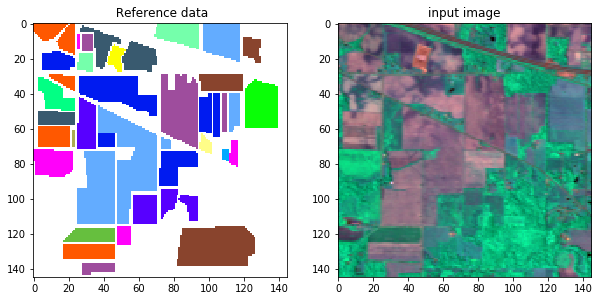

In [13]:
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title(' Reference data')

plt.imshow(gt_thematic_map)
fig.add_subplot(rows, columns, 2)
plt.title('input image')

plt.imshow(rgb_hyperspectral_image)

In [14]:
from sklearn.decomposition import PCA
number_of_pc = 10
pca = PCA(n_components=number_of_pc)
pc = pca.fit_transform(pixels)



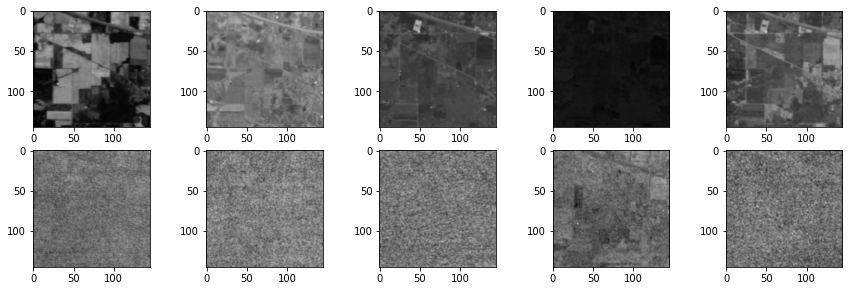

In [15]:
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 6
pc_images = np.zeros(shape=(number_of_rows, number_of_columns, number_of_pc))
for i in range(number_of_pc):
    pc_images[:, :, i] = np.reshape(pc[:, i], (number_of_rows, number_of_columns))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(pc_images[:, :, i], cmap='gray', interpolation='bicubic')

plt.show()

In [16]:
pc_images.shape,pc.shape,pixels.shape

((145, 145, 10), (21025, 10), (21025, 200))

# Train and Testing without generating extended morphological profiles

In [17]:
#gt=np.reshape(gt,(gt.shape[0]))

In [18]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train_w, x_test_w, y_train_w, y_test_w = train_test_split(
    pc, gt, test_size=0.75, random_state=0)

# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
clr = SVC(kernel='rbf', random_state=0,C=10,gamma=0.01)
clr.fit(x_train_w, y_train_w)



# Fitting KNeighborsClassifier to the Training set
from sklearn.neighbors import KNeighborsClassifier  
clr_k = KNeighborsClassifier(n_neighbors =13, weights='uniform', algorithm='auto')
clr_k.fit(x_train_w, y_train_w)

# Predicting the Test set results
y_pred=clr.predict(x_test_w) 
y_pred_k = clr_k.predict(x_test_w)


from sklearn.metrics import accuracy_score

acc=accuracy_score(y_test_w, y_pred)
acc_k=accuracy_score(y_test_w, y_pred_k)
print('the accurcy of SVM :',acc)
print('the accurcy of KNN :',acc_k)

C:\Users\rirok\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rirok\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


the accurcy of SVM : 0.7374595725791109
the accurcy of KNN : 0.7018200266345361


svm


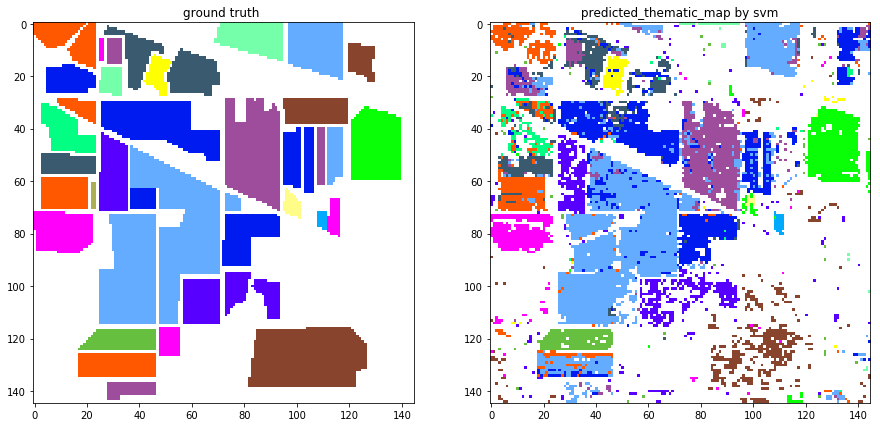

In [19]:
predicted_thematic_map = np.zeros(shape=(number_of_rows, number_of_columns, 3))
predicted_dataset = clr.predict(pc)

cont = 0
for i in range(number_of_rows):
    for j in range(number_of_columns):
        gt_thematic_map[i, j, :] = indianpines_colors[gt[cont, 0]]
        predicted_thematic_map[i, j, :] = indianpines_colors[predicted_dataset[cont]]
        cont += 1

fig = plt.figure(figsize=(15, 15))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('ground truth ')

plt.imshow(gt_thematic_map)
print('svm')
fig.add_subplot(rows, columns, 2)
plt.title(' predicted_thematic_map by svm ')

plt.imshow(predicted_thematic_map)
plt.show()

# Now Applying the extended morphological profiles to the data set

In [20]:
pc_images.shape
num_openings_closings = 4
morphological_profile_size = (num_openings_closings * 2) + 1

In [21]:
emp_image = build_emp(base_image=pc_images, num_openings_closings=num_openings_closings)

In [22]:
emp_image.shape

(145, 145, 90)

In [23]:
emp_image

array([[[  4.9091551 ,   8.56790519,   8.59877054, ...,  -0.62354306,
          -0.77269348,  -0.86916532],
        [  4.9091551 ,   8.56790519,   8.59877054, ...,  -0.62354306,
          -0.77269348,  -0.86916532],
        [  4.9091551 ,   8.56790519,   8.59877054, ...,  -0.62354306,
          -0.77269348,  -0.86916532],
        ...,
        [  5.95264058,   7.4253966 ,   8.31601961, ...,  -0.62354306,
          -0.77269348,  -0.86916532],
        [  5.95264058,   7.4253966 ,   8.31601961, ...,  -0.62354306,
          -0.77269348,  -0.86916532],
        [  5.95264058,   7.4253966 ,   8.31601961, ...,  -0.62354306,
          -0.77269348,  -0.86916532]],

       [[  4.9091551 ,   8.56790519,   8.59877054, ...,  -0.62354306,
          -0.77269348,  -0.86916532],
        [  4.9091551 ,   8.56790519,   8.59877054, ...,  -0.62354306,
          -0.77269348,  -0.86916532],
        [  4.9091551 ,   8.56790519,   8.59877054, ...,  -0.92282985,
          -0.92282985,  -0.92282985],
        ...,


In [24]:
dim_x, dim_y, dim_z = emp_image.shape
dim = dim_x * dim_y

x = np.zeros(shape=(dim, dim_z))
y = gt

cont = 0
for i in range(dim_x):
    for j in range(dim_y):
        x[cont, :] = emp_image[i, j, :]
        cont += 1


In [25]:
x.shape

(21025, 90)

In [26]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.75, random_state=0)

# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel='rbf', random_state=0,C=10,gamma=0.01)
classifier.fit(x_train, y_train)

from sklearn.neighbors import KNeighborsClassifier  


# Predicting the Test set results
y_pred = classifier.predict(x_test)

C:\Users\rirok\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
y.shape

(21025, 1)

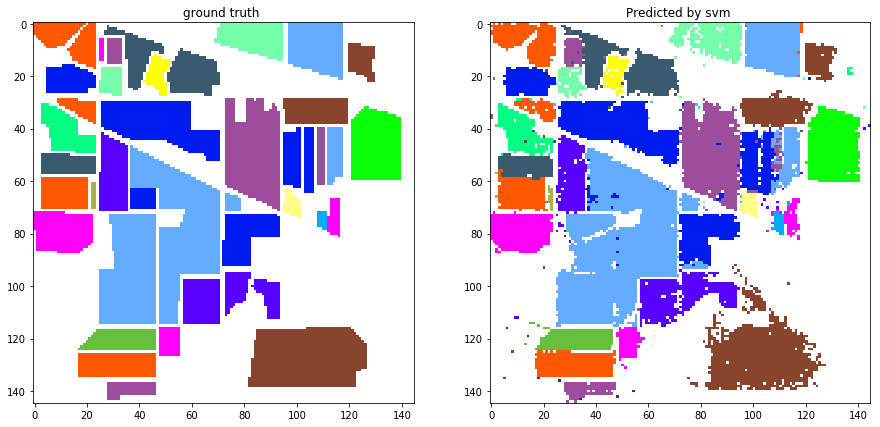

In [28]:
predicted_thematic_map = np.zeros(shape=(number_of_rows, number_of_columns, 3))
predicted_dataset = classifier.predict(x)

cont = 0
for i in range(number_of_rows):
    for j in range(number_of_columns):
        gt_thematic_map[i, j, :] = indianpines_colors[gt[cont, 0]]
        predicted_thematic_map[i, j, :] = indianpines_colors[predicted_dataset[cont]]
        cont += 1

fig = plt.figure(figsize=(15, 15))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('ground truth ')

plt.imshow(gt_thematic_map)
fig.add_subplot(rows, columns, 2)
plt.title('Predicted by svm ')

plt.imshow(predicted_thematic_map)
plt.show()

In [29]:
# Predicting the Test set results

y_pred=classifier.predict(x_test) 
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test, y_pred)

In [30]:
acc

0.9011985541251823

In [31]:
from sklearn.metrics import classification_report


cr = classification_report(y_test,y_pred,target_names=indianpines_class_names)



print(cr)

                        precision    recall  f1-score   support

            background       0.92      0.90      0.91      8022
               alfalfa       0.81      0.92      0.86        38
           corn-notill       0.89      0.88      0.88      1081
              corn-min       0.89      0.93      0.91       597
                  corn       0.86      0.87      0.87       169
         grass/pasture       0.88      0.85      0.86       378
           grass/trees       0.88      0.87      0.88       543
   grass/pasture-mowed       0.63      0.89      0.74        19
         hay-windrowed       0.93      0.98      0.96       377
                  oats       0.75      0.60      0.67        15
       soybeans-notill       0.91      0.88      0.89       730
          soybeans-min       0.89      0.95      0.92      1865
         soybean-clean       0.87      0.90      0.88       449
                 wheat       0.94      0.99      0.96       163
                 woods       0.83      

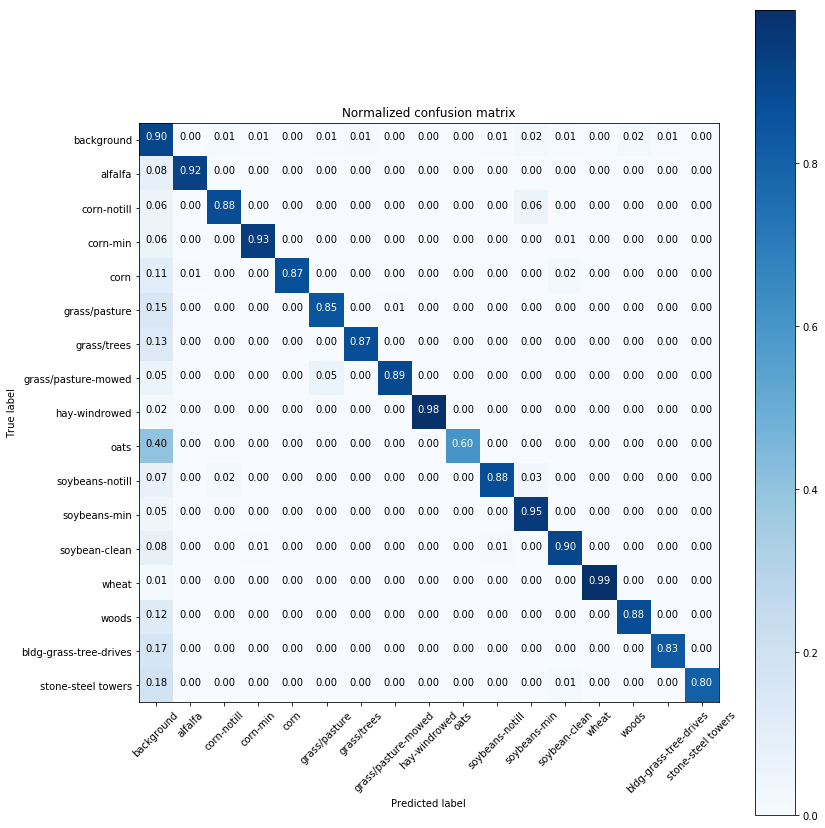

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the results
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot normalized confusion matrix
plt.figure(figsize=(12, 12))
plot_confusion_matrix(cm, classes=indianpines_class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [33]:
# Fitting Kernel SVM to the Training set
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors =13, weights='uniform', algorithm='auto')
classifier.fit(x_train, y_train)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

C:\Users\rirok\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\rirok\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


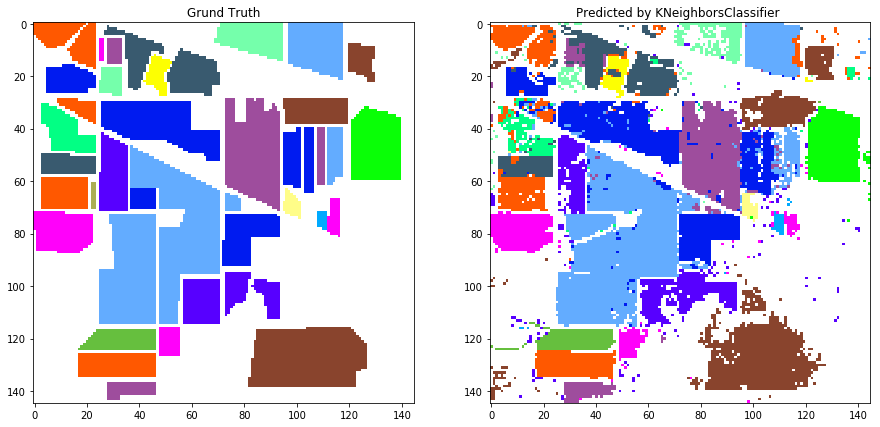

In [34]:
predicted_thematic_map = np.zeros(shape=(number_of_rows, number_of_columns, 3))
predicted_dataset = classifier.predict(x)

cont = 0
for i in range(number_of_rows):
    for j in range(number_of_columns):
        gt_thematic_map[i, j, :] = indianpines_colors[gt[cont, 0]]
        predicted_thematic_map[i, j, :] = indianpines_colors[predicted_dataset[cont]]
        cont += 1

fig = plt.figure(figsize=(15, 15))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Grund Truth')

plt.imshow(gt_thematic_map)
fig.add_subplot(rows, columns, 2)
plt.title('Predicted by KNeighborsClassifier ')

plt.imshow(predicted_thematic_map)
plt.show()

In [35]:
# Predicting the Test set results

y_pred=classifier.predict(x_test) 
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test, y_pred)

In [36]:
acc

0.850973428879447

In [37]:
from sklearn.metrics import classification_report


cr = classification_report(y_test,y_pred,target_names=indianpines_class_names)



print(cr)

                        precision    recall  f1-score   support

            background       0.89      0.85      0.87      8022
               alfalfa       0.86      0.82      0.84        38
           corn-notill       0.82      0.83      0.82      1081
              corn-min       0.76      0.85      0.80       597
                  corn       0.70      0.62      0.65       169
         grass/pasture       0.83      0.80      0.81       378
           grass/trees       0.73      0.78      0.76       543
   grass/pasture-mowed       0.53      0.84      0.65        19
         hay-windrowed       0.91      0.99      0.95       377
                  oats       0.00      0.00      0.00        15
       soybeans-notill       0.85      0.85      0.85       730
          soybeans-min       0.86      0.92      0.89      1865
         soybean-clean       0.78      0.84      0.81       449
                 wheat       0.87      0.98      0.92       163
                 woods       0.75      

C:\Users\rirok\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


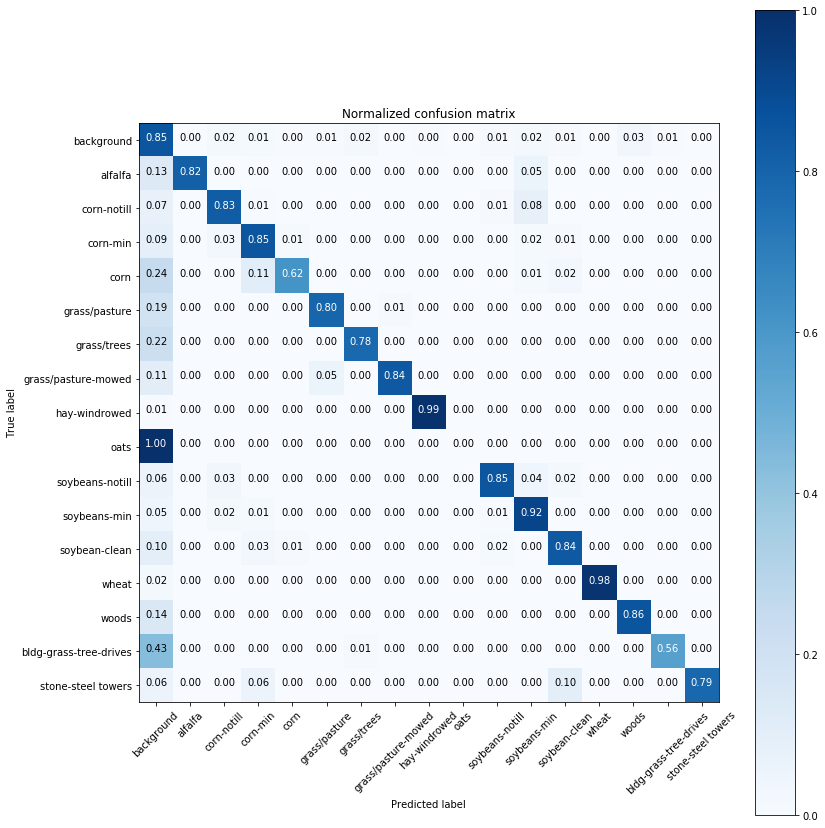

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the results
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot normalized confusion matrix
plt.figure(figsize=(12, 12))
plot_confusion_matrix(cm, classes=indianpines_class_names, normalize=True, title='Normalized confusion matrix')
plt.show()